<font face="B Mitra" size=4>
<div dir=rtl align=center>
<br>
<img src="https://aut.ac.ir/templates/tmpl_modern01/images/logo_fa.png" alt="Amirkabir University Logo" width="100">
<br>
<font size=6>
<b>Data Mining(Project 3)</b>
<br>
<font size=5>
<b>BBC News Article Clustering and Topic Modeling
</p>
<font size=4>
Implemented By: Rozhan Vassef
<br>
<font size=4> 2024
<hr>
</div>
</font>

<h2>
<font face="B Nazanin" color="black">
Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
# %config InlineBackend.figure_formats = ['svg']
import seaborn as sns

# Used to draw a progress bar for longer method calls
from tqdm import tqdm
tqdm.pandas()

# Pre-trained natural language processing pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

# Used to import list of punctuations
import string

# Feature extraction (text vectorizers)
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering and evaluation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer


# Topic modeling
from gensim.models import LdaModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

# Wordcloud
from wordcloud import WordCloud

# Grid search
from sklearn.model_selection import ParameterGrid

<h2>
<font face="B Nazanin" color="black">
Loading The Dataset

In [2]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')
df.head(5)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


<h2>
<font face="B Nazanin" color="black">
Preprocessing

<h4>
<font face="B Nazanin" color="#0099cc"><b>
1. Tokenization, removing extra characters and stemming</b>
</font>
</h4>
<font face="B Nazanin" size=4>
<font face="B Nazanin" color="#0099cc">
In this section, you should apply different types of preprocessing to the texts:
<ol>
<li>Tokenization of texts</li>
<li>Converting all letters to lowercase</li>
<li>Removing punctuation marks</li>
<li>Removing stop words</li>
<li>Lemmatization</li>
<li>Removing pronouns</li>
<li>Removing numbers</li>
<li>Removing words shorter than three letters</li>
</ol>
Save the processed texts in the <code>processed_content</code> column.
</font>
</p>
</div>

<font face="B Nazanin" size=4  color="#0099cc">
<b> <font color='#eb4034'> Note: </font></b>
Be careful in the order of the steps above. The order is not necessarily correct.
</font>
</p>


In [3]:
print(df.columns)

Index(['category', 'filename', 'title', 'content'], dtype='object')


In [4]:
import spacy
import string

# Load the spaCy language model (replace 'en_core_web_sm' with the desired model)
nlp = spacy.load('en_core_web_sm')

# Define a list of additional stop words or pronouns to remove
additional_stop_words = {'he', 'she', 'it', 'they', 'them', 'him', 'her'}

# Function to preprocess text
def preprocess_text_spacy(text):
    # Parse the text using spaCy
    doc = nlp(text)

    # Tokenization and preprocessing steps
    tokens = [
        token.lemma_.lower()  # Lemmatize and convert to lowercase
        for token in doc
        if not token.is_punct  # Remove punctuation
        and not token.is_stop  # Remove spaCy stopwords
        and not token.like_num  # Remove numbers
        and len(token.text) >= 3  # Remove words shorter than 3 letters
        and token.text.lower() not in additional_stop_words  # Remove additional stop words (including pronouns)
    ]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text

# Apply preprocessing to the text column and save to 'processed_content'
df['processed_content'] = df['content'].apply(preprocess_text_spacy)

# Print the processed DataFrame
print(df[['content', 'processed_content']].head())


                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                   processed_content  
0  quarterly profit medium giant timewarner jump ...  
1  dollar hit high level euro month federal reser...  
2  owner embattle russian oil giant yukos ask buy...  
3  british airways blame high fuel price drop pro...  
4  share drink food firm allied domecq rise specu...  


<font face="B Nazanin" size=4 color="#0099cc">
The common stop words provided by libraries do not include all unnecessary words. In this section, first find the number of each word in the tokenized data, then from the 100 most frequent words, add the words you think are unimportant to the stop word list
and remove them as well.
</font>
</p>
</div>

In [5]:
from collections import Counter
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

# Tokenize all processed content to analyze word frequencies using spaCy
def tokenize_with_spacy(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_punct and not token.is_stop]

# Flatten all tokens into a single list
all_tokens = [token for text in df['processed_content'] for token in tokenize_with_spacy(text)]

# Count word frequencies
word_freq = Counter(all_tokens)

# Get the 100 most common words
most_common_words = word_freq.most_common(100)

# Print the most common words for manual inspection
print("Most common words:", most_common_words)

# Add additional stopwords based on manual inspection
custom_stopwords = {'word1', 'word2', 'word3'}  # Replace with unimportant words from most_common_words

# Function to remove custom stopwords from the text
def remove_custom_stopwords_spacy(text):
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if token.text.lower() not in custom_stopwords
    ]
    return ' '.join(tokens)

# Remove custom stopwords from processed content
df['processed_content'] = df['processed_content'].apply(remove_custom_stopwords_spacy)

# Print the updated DataFrame
print(df[['processed_content']].head())


Most common words: [('year', 3287), ('people', 2043), ('new', 1926), ('good', 1552), ('time', 1534), ('win', 1427), ('game', 1424), ('world', 1205), ('come', 1198), ('government', 1194), ('play', 1155), ('film', 1116), ('company', 1107), ('work', 1071), ('tell', 1053), ('firm', 972), ('want', 956), ('add', 947), ('like', 936), ('think', 929), ('month', 884), ('number', 884), ('include', 860), ('way', 852), ('service', 848), ('country', 837), ('market', 833), ('player', 822), ('set', 821), ('high', 818), ('plan', 817), ('music', 815), ('week', 802), ('need', 791), ('party', 790), ('look', 775), ('labour', 774), ('big', 772), ('report', 760), ('bbc', 751), ('day', 740), ('home', 736), ('election', 721), ('minister', 719), ('sale', 710), ('know', 702), ('expect', 683), ('technology', 662), ('use', 656), ('help', 649), ('rise', 648), ('find', 640), ('right', 636), ('end', 632), ('start', 626), ('mobile', 624), ('group', 622), ('phone', 605), ('run', 601), ('england', 597), ('try', 591), ('

<font face="B Nazanin" size=4 color="#0099cc">
Since the above process is a bit time consuming, you can do it once and save the dataframe by executing the following block.
</font>
</p>
</div>

In [6]:
pickle.dump(df, open("processed_df.pkl", "wb"))

<font face="B Nazanin" size=4 color="#0099cc">
You can also load the saved dataframe by executing the following block:.
</font>
</p>
</div>

In [7]:
df = pickle.load(open("processed_df.pkl", "rb"))

<h4>
<font face="B Nazanin" color = 'black'>
<b>2. Feature extraction from texts</b>
</font>
</h4>
<font face="B Nazanin" size=4 color="#0099cc">
Create the feature matrix of the texts using
<code>TfidfVectorizer</code>
.
</font>
</p>
</div>

In [8]:
# TODO - tf-idf vectorization (set max_features to 8192)
from sklearn.feature_extraction.text import TfidfVectorizer

# TODO - tf-idf vectorization (set max_features to 8192)
tfidf_vectorizer = TfidfVectorizer(max_features=8192)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_content'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (2225, 8192)


<font face="B Nazanin" size=4 color="#0099cc">
What is the intuition behind TF-IDF feature extraction? How is it different from simply counting the number of words in each text?
</font>
</p>


<font face="B Nazanin">
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> Explanation: </font></b>
</p>TF-IDF (Term Frequency-Inverse Document Frequency):
Gives importance to words by considering their frequency of occurrence (TF) and their uniqueness (IDF). It highlights distinctive words while downplaying common words. Unlike simple word counts, which overemphasize common words like "the," TF-IDF highlights what makes a text unique in that context.
</p>
</font>
</div>
</font>
<hr>

<h2>
<font face="B Nazanin" color="black">
Clustering

<h4>
<font face="B Nazanin" color="#0099cc">
<b>-Dimensionality reduction by PCA</b>
</font>
</h4>
<font face="B Nazanin" size=4 color="#0099cc">
Reduce the dimensionality of the feature matrix using
<code>PCA</code>.
</font>
</p>
</div>

In [9]:
# TODO - PCA dimensionality reduction (set n_components to 0.95)
from sklearn.decomposition import PCA

# TODO - PCA dimensionality reduction (set n_components to 0.95)
pca = PCA(n_components=0.95)
reduced_matrix = pca.fit_transform(tfidf_matrix.toarray())  # Convert sparse to dense for PCA

print("Reduced Matrix Shape (after PCA):", reduced_matrix.shape)

Reduced Matrix Shape (after PCA): (2225, 1530)


<font face="B Nazanin" size=4 color="#0099cc">
Most clustering algorithms, including K-Means, do not work well with high-dimensional data, so dimensionality reduction can help us deal with this problem.
Explain in one or two lines why this is the case..
</font>
</p>


<font face="B Nazanin">
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> Explanation: </font></b>
In high-dimensional spaces, the distances between different points tend to be similar, making it difficult for clustering algorithms to distinguish between them. Dimensionality reduction (e.g., PCA) helps by compressing the data into fewer dimensions while preserving the overall structure.
In fact,
high-dimensional data causes clustering algorithms to suffer from the "curse of dimensionality," where the distances between points lose their meaning. PCA reduces dimensionality while preserving most of the variance, making clustering more efficient.
</p>
</font>
</div>
</font>
<hr>

<font face="B Nazanin" size=4 color="#0099cc">
Cluster the documents using the <code>KMeans</code> clustering algorithm.
</p>
To determine the best number of clusters, use the Distortion criterion and draw an Elbow Plot for the clusterings with K=2 to K=30.
</p>
If no useful information can be extracted from the Elbow Plot, compare the said clusterings with the Normalized Mutual Information criterion.
</font>
</p>
</div>

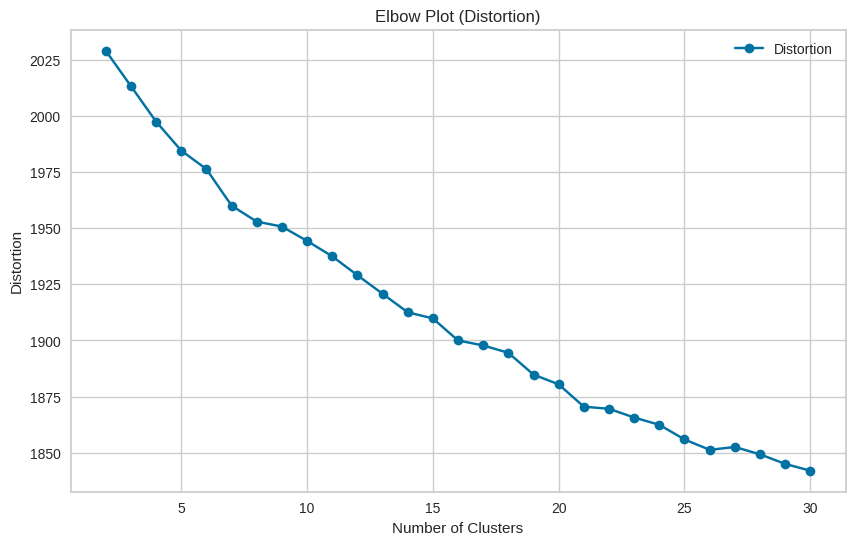

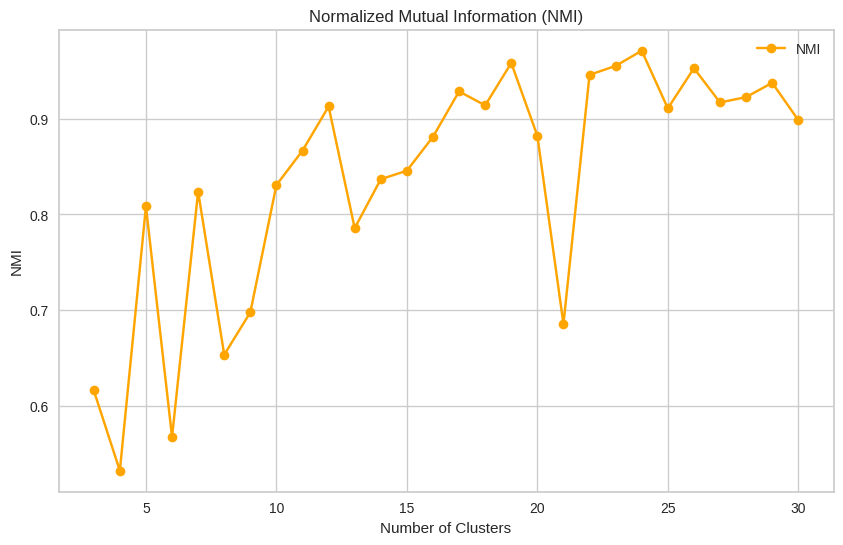

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables
distortions = []
nmi_scores = []  # NMI between consecutive clusterings
K_range = range(2, 31)

# Perform KMeans clustering and collect metrics
previous_labels = None

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_matrix)

    # Append distortion (inertia)
    distortions.append(kmeans.inertia_)

    # Compute NMI between consecutive k-means clusterings
    if previous_labels is not None:
        nmi = normalized_mutual_info_score(previous_labels, kmeans.labels_)
        nmi_scores.append(nmi)

    # Update the previous labels for the next iteration
    previous_labels = kmeans.labels_

# Elbow Plot (Distortion)
plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, marker='o', label='Distortion')
plt.title('Elbow Plot (Distortion)')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.legend()
plt.show()

# Plot NMI (if calculated)
if nmi_scores:
    plt.figure(figsize=(10, 6))
    plt.plot(K_range[1:], nmi_scores, marker='o', color='orange', label='NMI')
    plt.title('Normalized Mutual Information (NMI)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('NMI')
    plt.grid(True)
    plt.legend()
    plt.show()

<font face="B Nazanin" size=4 color="#0099cc">
After choosing the best number of clusters, train the clustering model with this number. Then add a column named <code>cluster</code> to the dataframe that represents the clusters that the model predicted for each sample..

</font>
</p>
</div>

In [11]:
# TODO - KMeans clustering with optimal number of clusters
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(reduced_matrix)

# Save clustered DataFrame
import pickle
pickle.dump(df, open("clustered_df.pkl", "wb"))
df = pickle.load(open("clustered_df.pkl", "rb"))
print(df[['processed_content', 'cluster']].head())

                                   processed_content  cluster
0  quarterly profit medium giant timewarner jump ...       10
1  dollar hit high level euro month federal reser...        1
2  owner embattle russian oil giant yukos ask buy...        8
3  british airways blame high fuel price drop pro...       10
4  share drink food firm allied domecq rise specu...       10


In [12]:
pickle.dump(df, open("clustered_df.pkl", "wb"))

In [13]:
df = pickle.load(open("clustered_df.pkl", "rb"))

<h4>
<font face="B Nazanin" color = 'black'>
<b>Displaying the clustering</b>
</font>
</h4>
<font face="B Nazanin" size=4 color="#0099cc">
Reduce the feature matrix dimensions to 2 dimensions using the <code>t-SNE</code> algorithm and draw the clustering diagram.
</font>
</p>
</div>

In [14]:
# TODO - TSNE dimensionality reduction
from sklearn.manifold import TSNE

# TODO - TSNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(reduced_matrix)

# Add t-SNE results to DataFrame for visualization
df['tsne_x'] = tsne_result[:, 0]
df['tsne_y'] = tsne_result[:, 1]

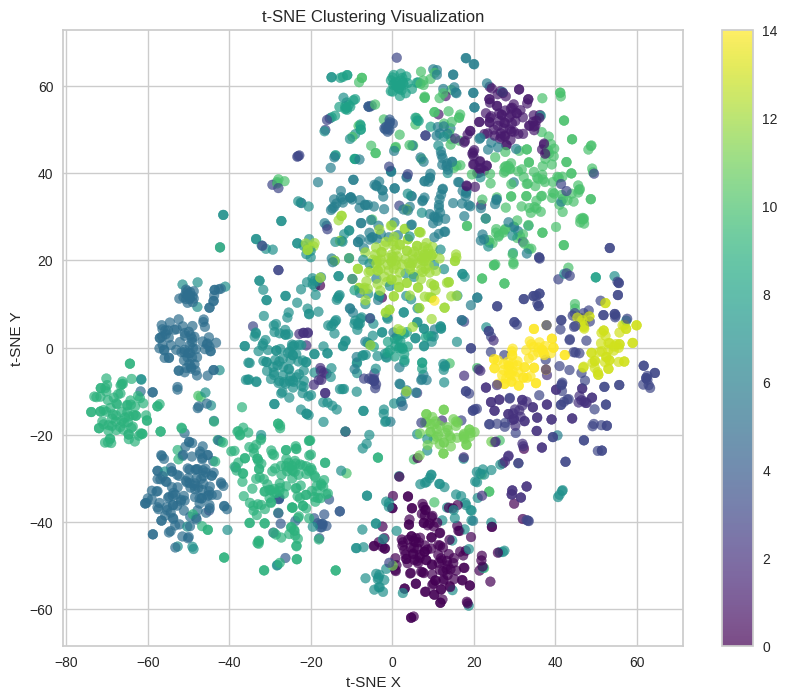

In [15]:
# TODO - visualize the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Clustering Visualization')
plt.xlabel('t-SNE X')
plt.ylabel('t-SNE Y')
plt.show()

<font face="B Nazanin" size=4 color="#0099cc">
In 4 lines or less, explain intuitively how the t-SNE algorithm works. No need to refer to mathematical symbols or relationships.
</font>
</p>


<font face="B Nazanin">
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> Explanation: </font></b>
t-SNE
(t-distributed Stochastic Neighbor Embedding)
reduces high-dimensional data to 2D or 3D while preserving the relationships between nearby points.
It does this by placing similar points close together and pushing away dissimilar points, creating a visual "map" of the data that reflects the overall structure.
It finds patterns in the data based on the similarity of data points to features, the similarity of points being calculated by conditional probability.
It then attempts to minimize the difference between these probabilities (or similarities) in the higher-dimensional and lower-dimensional space to fully represent the data points in the lower-dimensional space.
</p>
</font>
</div>
</font>
<hr>

<h2>
<font face="B Nazanin" color="black">
Topic Modeling

<div dir=rtl>
<font face="B Nazanin" size=4>
در مورد دو الگوریتم استخراج موضوع
<code>Latent Dirichlet Allocation</code> و
<code>Non-Negative Matrix Factorization</code>
مطالعه کرده و به طور خلاصه (بدون نیاز به اشاره به جزئیات ریاضی) نحوه‌ی کارکرد هر یک را توضیح دهید؛
سپس، یکی از این دو الگوریتم را برای ادامهٔ کار انتخاب کنید.
</font>
</p>
</div>

<font face="B Nazanin">
<div dir=rtl>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> توضیحات پاسخ: </font></b>  

</p>
</font>
</div>
</font>
<hr>

<font face="B Nazanin" size=4 color="#0099cc">
You must perform topic modeling on the data for each cluster separately.
Note that when using the <code>gensim</code> library, you must first create a dictionary and BoW (Bag of Words) for each cluster.
</font>
</p>
</div>

In [16]:
# TODO - make Dictionary and Corpus for each cluster
from gensim.corpora import Dictionary
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

# Group the data by clusters
clusters = df.groupby('cluster')

# TODO - make Dictionary and Corpus for each cluster
dictionaries = {}
corpora = {}

for cluster_id, group in clusters:
    texts = group['processed_content'].apply(lambda x: x.split())
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    dictionaries[cluster_id] = dictionary
    corpora[cluster_id] = corpus

<font face="B Nazanin" size=4 color="#0099cc">
Next, you need to find the best number of topics for each cluster by examining Topic Coherence under the criterion
<code>C_V</code>.
For each cluster, keep the model that had the highest value of the criterion
.
<br>
It is sufficient to examine the number of topics 5, 10, 15, 20 and 25.
</font>
</p>
</div>

In [17]:
# TODO - find the optimal number of topics for each cluster
optimal_topics = {}

# TODO - find the optimal number of topics for each cluster
for cluster_id, corpus in corpora.items():
    dictionary = dictionaries[cluster_id]
    best_model = None
    best_coherence = -1
    best_num_topics = 0

    for num_topics in [5, 10, 15, 20, 25]:
        nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

        # Compute C_V coherence
        coherence_model = CoherenceModel(model=nmf_model, texts=df[df['cluster'] == cluster_id]['processed_content'].apply(lambda x: x.split()),
                                         dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_model = nmf_model
            best_num_topics = num_topics

    optimal_topics[cluster_id] = (best_model, best_num_topics)
    print(f"Cluster {cluster_id}: Best Number of Topics = {best_num_topics}, Coherence = {best_coherence}")


Cluster 0: Best Number of Topics = 5, Coherence = 0.39470266032668083
Cluster 1: Best Number of Topics = 5, Coherence = 0.3571786872365922
Cluster 2: Best Number of Topics = 25, Coherence = 0.357416322228663
Cluster 3: Best Number of Topics = 10, Coherence = 0.3291789376368256
Cluster 4: Best Number of Topics = 5, Coherence = 0.5158507430077048
Cluster 5: Best Number of Topics = 5, Coherence = 0.5017766314352112
Cluster 6: Best Number of Topics = 5, Coherence = 0.3735812633866701
Cluster 7: Best Number of Topics = 5, Coherence = 0.41883770219221106
Cluster 8: Best Number of Topics = 25, Coherence = 0.43586216886859186
Cluster 9: Best Number of Topics = 15, Coherence = 0.41980789511976385
Cluster 10: Best Number of Topics = 25, Coherence = 0.3372970122447295
Cluster 11: Best Number of Topics = 5, Coherence = 0.4281307314285817
Cluster 12: Best Number of Topics = 10, Coherence = 0.3669113514121229
Cluster 13: Best Number of Topics = 25, Coherence = 0.40431447617692484
Cluster 14: Best Nu

<font face="B Nazanin" size=4 color="#0099cc">
Briefly explain how to calculate the <code>C_V</code>.
</font>
</p>


<font face="B Nazanin">
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> Explanation: </font></b>
The CV coherence measure assesses the interpretability of topics by measuring the degree of semantic similarity between words that score high in each topic. It creates content vectors of words using their co-occurrences and then calculates the score using normalized point mutual information (NPMI) and cosine similarity.
</p>
</font>
</div>
</font>
<hr>

<h4>
<font face="B Nazanin" color = 'black'>
<b>Extracting keywords from topics</b>
</font>
</h4>
<font face="B Nazanin" size=4 color="#0099cc">
Next, for each data point in the dataframe, you need to extract the top 3 topics that the model predicted. Then, extract 2 important keywords from each topic.
</font>
</p>
</div>

In [18]:
# TODO - extract keywords for each document
final_df = df.copy()
top_keywords_list = []

# TODO - extract keywords for each document
for idx, row in final_df.iterrows():
    cluster_id = row['cluster']
    text_bow = dictionaries[cluster_id].doc2bow(row['processed_content'].split())
    nmf_model = optimal_topics[cluster_id][0]

    # Get the topic distribution for the document
    topic_probs = nmf_model[text_bow]
    sorted_topics = sorted(topic_probs, key=lambda x: -x[1])[:3]  # Top 3 topics

    # Extract top 2 keywords for each topic
    keywords = []
    for topic_id, prob in sorted_topics:
        topic_keywords = [word for word, _ in nmf_model.show_topic(topic_id, topn=2)]
        keywords.extend(topic_keywords)

    top_keywords_list.append(keywords)

In [19]:
final_df['top_keywords'] = top_keywords_list

In [20]:
pickle.dump(final_df, open("final_df.pkl", "wb"))

In [21]:
final_df = pickle.load(open("final_df.pkl", "rb"))

<h2>
<font face="B Nazanin" color="#0099cc">
Displaying clusters and topics

<font face="B Nazanin" size=4 color="#0099cc">
Using the code below, you can view clustering and topic graphs.
<br>
<font color='#eb4034'>
The data frame structure given to the code below should be exactly as follows::
</font>
</font>
</p>
</div>

<center>
<table style="direction: rtl;align: center; text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <tr><td><code>x</code></td><td>Column x of the feature matrix reduced to 2 dimensions with TSNE</td>
  </tr>
<tr><td><code>y</code></td><td>Column y of the feature matrix reduced to 2 dimensions with TSNE</td>
  </tr>
<tr><td><code>cluster</code></td><td>Predicted cluster for the data</td>
  </tr>
<tr>
      <td><code>top_keywords</code></td><td>Keywords extracted for data*</td>

</table>
</center>

<font face="B Nazanin" size=4 color="#0099cc">
<br>*Note that the values ​​in this column must be in the form of
<code>string</code>
and separated only by the symbol
<code>|</code>
.
For example:
<code>word1|word2|word3</code>

  

In [22]:
# Install Dash and other required packages
!pip install dash
!pip install jupyter-dash
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 3.3 MB/s eta 0:00:00


In [23]:
# Transform 'top_keywords' column to a string with '|' separator
final_df['top_keywords'] = final_df['top_keywords'].apply(lambda keywords: '|'.join(keywords))

# Select and rename columns as required
final_df = final_df.rename(columns={'tsne_x': 'x', 'tsne_y': 'y'})[['x', 'y', 'cluster', 'top_keywords']]

In [26]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df_dash = final_df.copy()

# Split the keywords for processing
df_dash['keywords_list'] = df_dash['top_keywords'].str.split('|')

# Initialize Dash app
app = dash.Dash(__name__)

# Create the layout
app.layout = html.Div([
    html.Div([
        html.H4(" t-SNE Plot with Keyword Search"),
        dcc.Graph(id='scatter-plot'),
        html.Label("Search for a keyword:"),
        dcc.Input(id='keyword-search', type='text', placeholder='Enter keyword', debounce=True),
    ], style={'width': '75%', 'display': 'inline-block', 'backgroundColor': '#ffffff'}),

    html.Div([
        html.H4(" Most Frequent Keywords"),
        html.Div(id='keyword-panel', style={'backgroundColor': '#f0f0f5', 'padding': '10px', 'borderRadius': '5px'})
    ], style={'width': '25%', 'display': 'inline-block', 'verticalAlign': 'top', 'backgroundColor': '#f0f0f5'})
])

# Callback for updating the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('keyword-search', 'value')]
)
def update_scatter(search_keyword):
    # Create a highlight column based on the search keyword
    if search_keyword:
        df_dash['highlight'] = df_dash['keywords_list'].apply(lambda x: any(search_keyword.lower() in k.lower() for k in x))
    else:
        df_dash['highlight'] = True  # Highlight all points if no keyword is searched

    # Prepare data for plotting
    highlighted_df = df_dash[df_dash['highlight']]
    non_highlighted_df = df_dash[~df_dash['highlight']]

    # Create scatter plot with highlighted and non-highlighted points
    fig = go.Figure()

    # Add non-highlighted points (gray color)
    fig.add_trace(go.Scatter(
        x=non_highlighted_df['x'],
        y=non_highlighted_df['y'],
        mode='markers',
        marker=dict(color='gray', size=8, opacity=0.4),
        name='Non-Highlighted',
        text=non_highlighted_df['top_keywords'],  # Add top_keywords to hover
        hoverinfo='text'  # Show only the top_keywords on hover
    ))

    # Add highlighted points with cluster colors
    for cluster in df_dash['cluster'].unique():
        cluster_df = highlighted_df[highlighted_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'],
            y=cluster_df['y'],
            mode='markers',
            marker=dict(size=8, opacity=0.8),
            name=f'Cluster {cluster}',
            marker_color=px.colors.qualitative.Light24[cluster],
            text=cluster_df['top_keywords'],  # Add top_keywords to hover
            hoverinfo='text'  # Show only the top_keywords on hover
        ))

    # Update layout
    fig.update_layout(
        title="t-SNE Plot",
        xaxis_title="X",
        yaxis_title="Y",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

# Callback for updating the keyword panel
@app.callback(
    Output('keyword-panel', 'children'),
    [Input('scatter-plot', 'figure')]
)
def update_keyword_panel(_):
    # Flatten the list of keywords and compute most frequent ones
    all_keywords = [keyword for keywords in df_dash['keywords_list'] for keyword in keywords]
    keyword_counts = pd.Series(all_keywords).value_counts().head(40)
    return [html.Li(f"{kw}: {count}") for kw, count in keyword_counts.items()]


# Run the app
if __name__ == '__main__':
    app.run(debug=True, jupyter_height=1200, port=8050)


<IPython.core.display.Javascript object>

<h2>
<font face="B Nazanin" color="black">
Word Clouds

<font face="B Nazanin" size=4 color="#0099cc">
In this section, you need to draw Word Clouds for the keywords in each cluster.
</p>
First, you need to find the number of times each cluster’s keywords are repeated.
</p>
(Consider only the top 10 keywords from each topic)
</p>
Then draw Word Clouds using the keywords and their frequency..
</font>
</p>
</div>


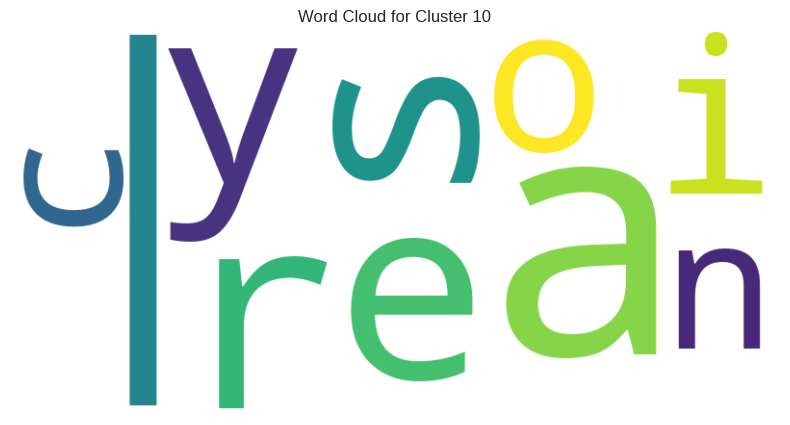

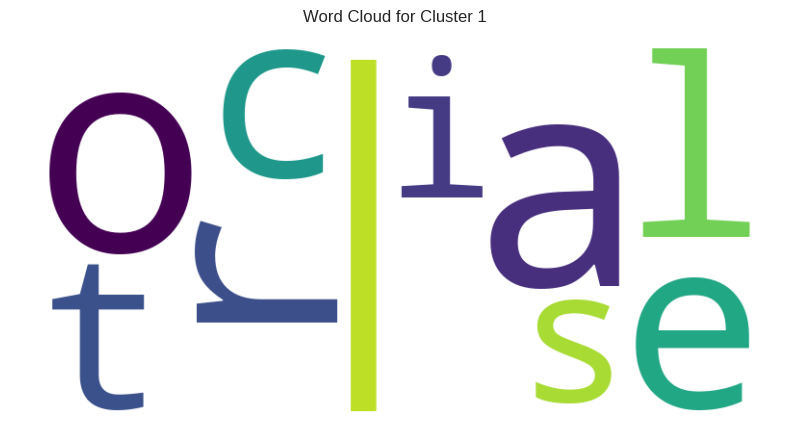

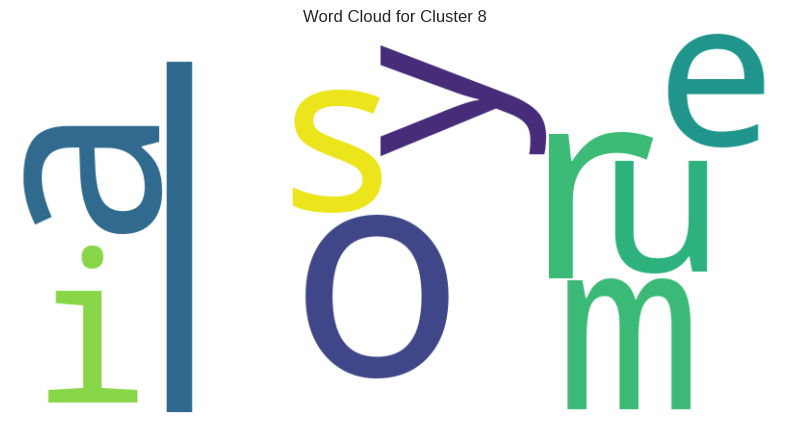

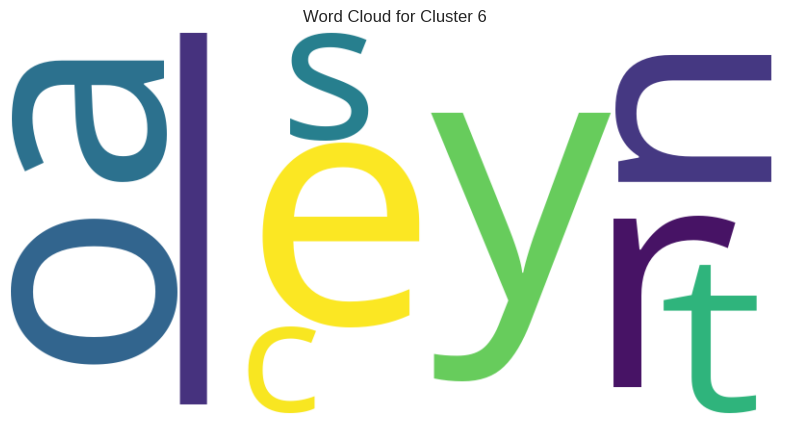

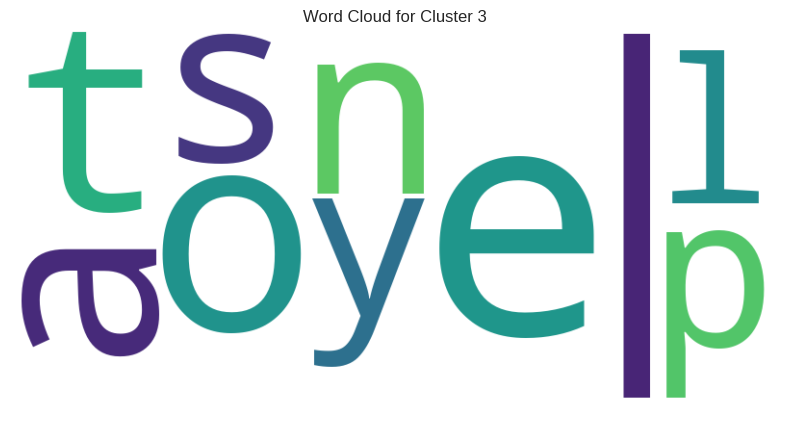

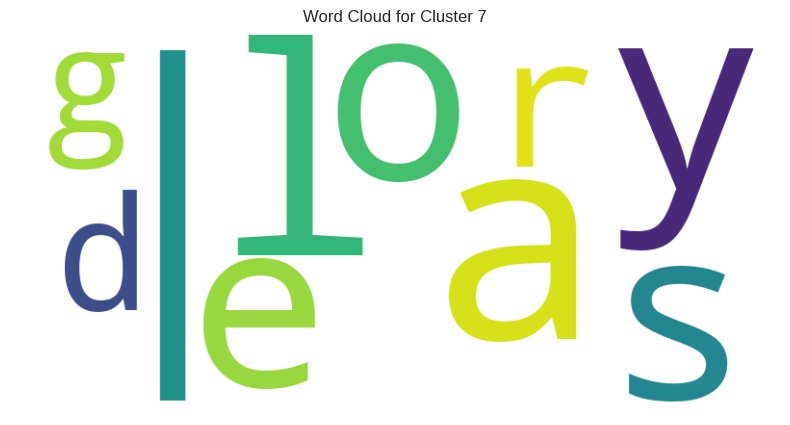

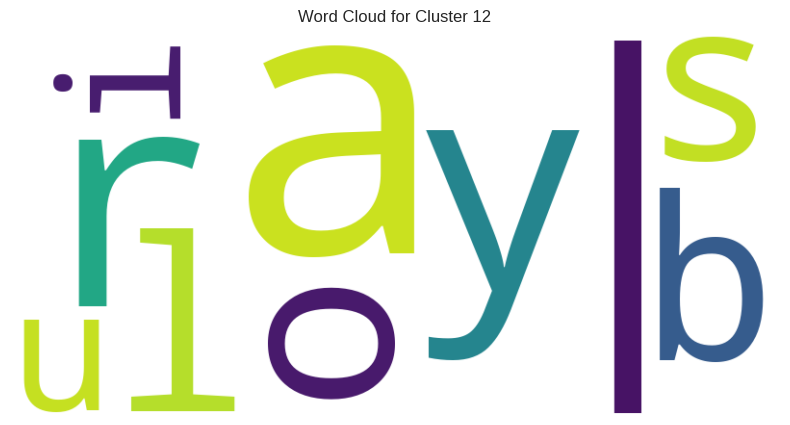

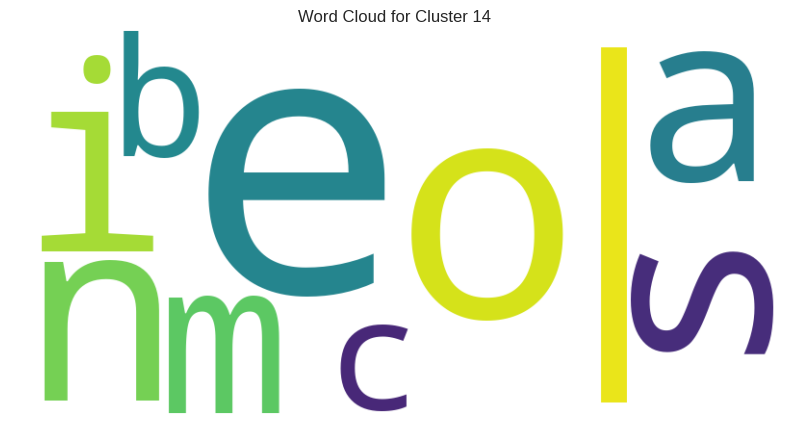

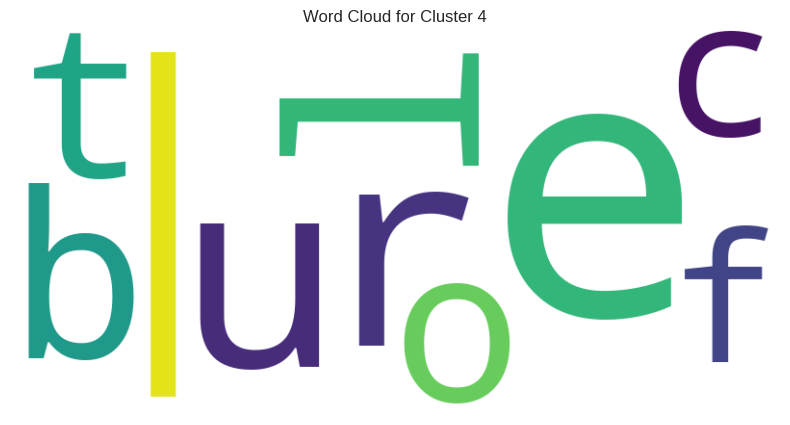

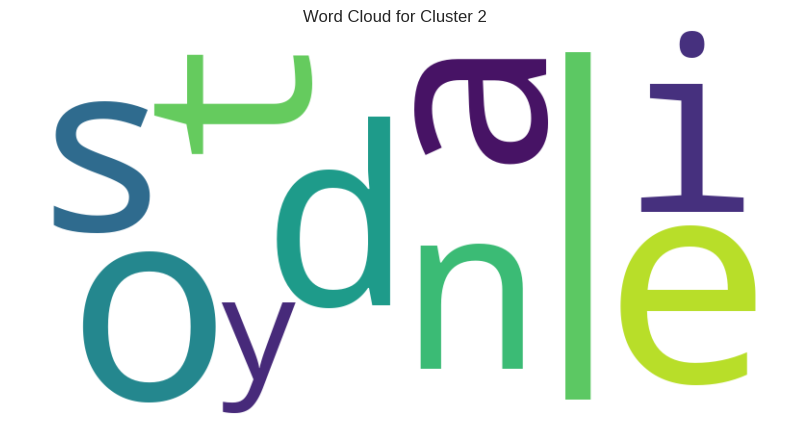

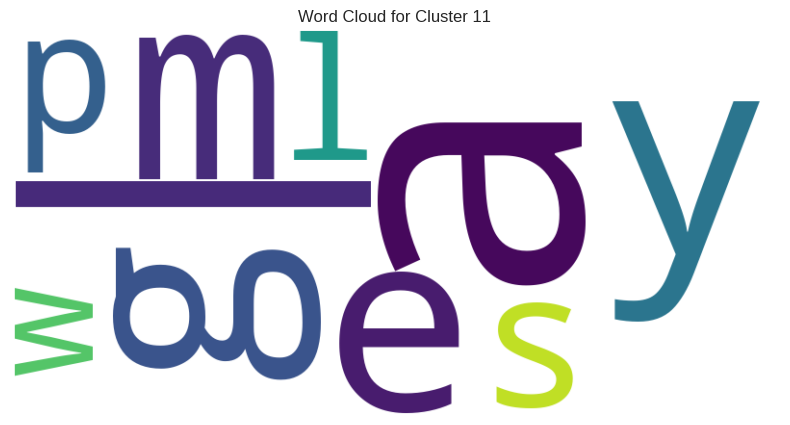

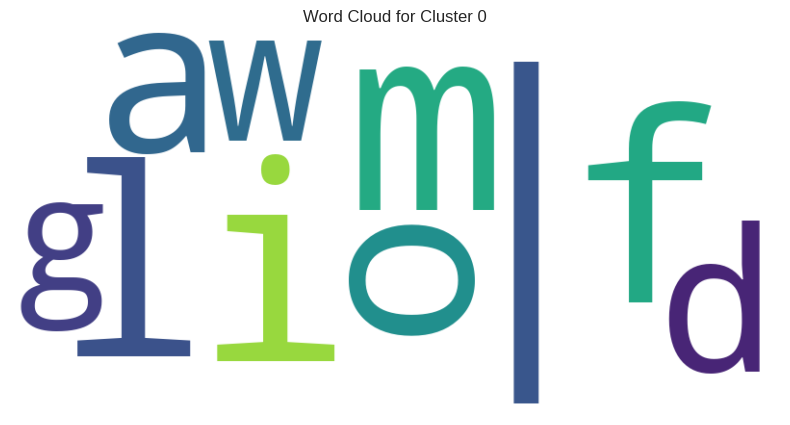

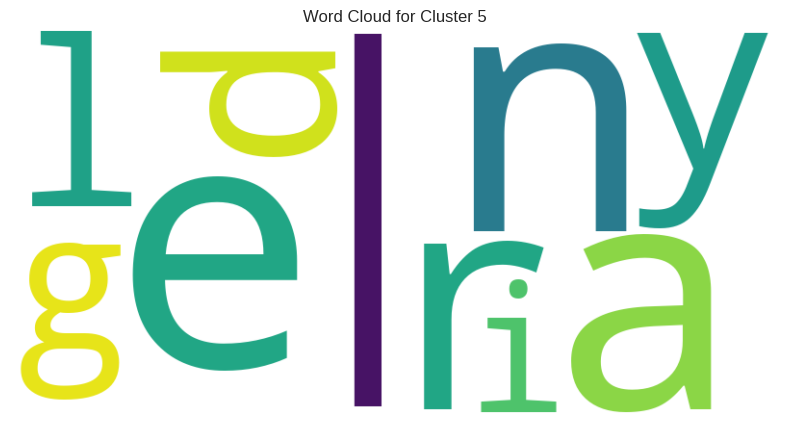

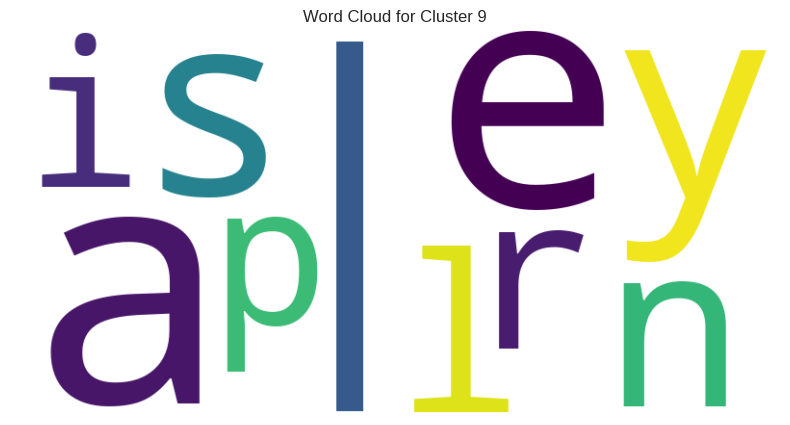

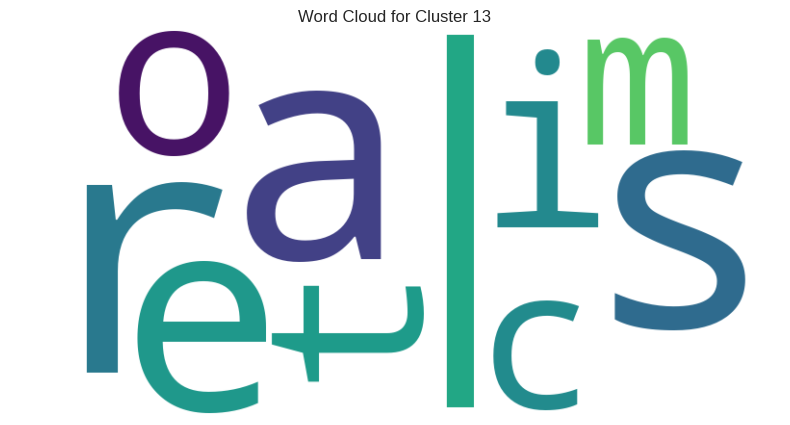

In [27]:
#TODO - count keywords repetitions and plot wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# TODO - count keywords repetitions and plot wordclouds
cluster_keywords = {}

# Count keyword repetitions for each cluster
for cluster_id in final_df['cluster'].unique():
    # Filter the data for the cluster
    cluster_data = final_df[final_df['cluster'] == cluster_id]

    # Flatten the list of top_keywords and count occurrences
    all_keywords = [keyword for keywords in cluster_data['top_keywords'] for keyword in keywords]
    keyword_counts = Counter(all_keywords)

    # Keep only the top 10 keywords
    cluster_keywords[cluster_id] = dict(keyword_counts.most_common(10))

# Plot word clouds for each cluster
for cluster_id, keywords_freq in cluster_keywords.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.axis('off')
    plt.show()